In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math
from sklearn.datasets import load_iris
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import cross_val_score
import random
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings("ignore")
from analysis_functions import *


def transform_neural_data_lda(activity_list, behaviour_list,parameters_time,parameters_list,parameters_list2,timeline,trial_list, trial_flag = False):
    
    day = 0
    clf = LDA()
    activity_list_lda = []
    
    if trial_flag:  
        activity_list_lda_trial = []
        trial_list_new_trial= np.zeros((20,))
        
    trial_list_new = np.zeros_like(trial_list)
    for day in range(len(trial_list)):
        if trial_list[day]:
            if activity_list[day].shape[1] == behaviour_list[day].shape[0]:
                trial_list_new[day] = trial_list[day]
                ### run pca on the entire dataset
                X = activity_list[day].T
                y = behaviour_list[day]
                X_transformed = clf.fit(X, y).transform(X)
                #X_lda_transformed = embedding.fit_transform(X_transformed.T)
                activity_list_lda.append(X_transformed.T)

                if trial_flag:
                    for i in range(5):
                        time1 = int(timeline[day][2*i])
                        time2 = int(timeline[day][2*i+1])
                        time3 = int(timeline[day][2*(i+1)])
                        trial_list_new_trial[day*5+i] = day*5+i+1
                        activity_list_lda_trial.append(X_transformed[time1:time2,:].T)  
            else:
                trial_list_new[day] = 0
                activity_list_lda.append([])
                
                if trial_flag:
                    for i in range(5):
                        trial_list_new_trial[day*5+i] = 0
                        activity_list_lda_trial.append([]) 
        else:
            if trial_flag:
                for i in range(5):
                    trial_list_new_trial[day*5+i] = 0
                    activity_list_lda_trial.append([]) 
            trial_list_new[day] = 0
            activity_list_lda.append([])

            continue
    
    data_transformation = namedtuple('data_transformation', ['lda','trials'])
    if trial_flag:
        return data_transformation(activity_list_lda_trial,trial_list_new_trial)
    else:
        return data_transformation(activity_list_lda,trial_list_new)
    
def create_trial_activity_list(activity_events,events_id,trial_list):
    
    trial_activity_lda,new_list = create_visits_matrix(activity_events.lda,events_id,trial_list)

    trial_activity = namedtuple('trial_activity', ['lda','trials'])    
    return trial_activity(trial_activity_lda,new_list)

def create_trial_activity_list_shuffle(activity_events_shuffle,events_id, N_SHUFFLINGS,trial_list):
 
    trial_activity_lda= create_visits_matrix_shufflings(activity_events_shuffle.lda,events_id,N_SHUFFLINGS,trial_list)
    trial_activity_shuffle = namedtuple('trial_activity_shuffle', ['lda'])
    return trial_activity_shuffle(trial_activity_lda)

def create_events_data_transformation(activity_list,data_transformation,period,events,events_counter,events_onset,events_id,events_b,trial_list):

    events_activity_lda, events_duration = create_activity_events(data_transformation.lda,period,events,events_counter,events_onset,events_id,events_b,trial_list)
    
    events = namedtuple('events', ['lda'])    
    return events(events_activity_lda)

def create_events_data_transformation_shuffling(activity_list,data_transformation,period,events_shuffle_b,events_counter,events_onset,events_id,events_s_b, N_SHUFFLINGS,trial_list):
    
    events_activity_shuffle_lda = create_activity_events_shuffle(data_transformation.lda,period,events_shuffle_b,events_counter,events_onset,events_id,events_s_b, N_SHUFFLINGS,trial_list)

    events = namedtuple('events', ['lda'])    
    return events(events_activity_shuffle_lda)
    
def compute_distance_lda(trial_activity, trial_activity_shuffle, data_transformation, N_SHUFFLINGS,trial_list,events_id,metric = 'Euclidean',trial_flag = False):
    
    lda_components = []
    
    for day in range(len(trial_activity.lda)):
        if trial_list[day]:
            print(day)
            lda_components.append(trial_activity.lda[day].shape[1])
        else:
            lda_components.append([])

    lda_min = 4
    for i in range(len(lda_components)):
        lda_components[i] = lda_min
            
    distance_lda, z_scored_lda = compute_representational_distance_all_to_all(trial_activity.lda,trial_activity_shuffle.lda,lda_components, N_SHUFFLINGS,trial_list,events_id,metric,trial_flag)

    non_nan_z_scored_lda = np.nan_to_num( np.nansum([z_scored_lda,z_scored_lda.T],axis = 0),neginf=0)
    
    distance = namedtuple('distance', ['lda'])
    return distance(non_nan_z_scored_lda)
    

def compute_distance(activity_list,data_transformation,period,behaviour_list,id_target,N_SHUFFLINGS,trial_list, metric = 'Euclidean',trial_flag = False):
    
    print('CREATE LIST THAT SAVES ALL THE EVENTS IN A DAY AND CONTAINS ONSET OF VISITS')
    events_etho, events_shuffle_etho,events_counter_etho,events_onset_etho = create_events_list(behaviour_list, N_SHUFFLINGS,trial_list)
    print('NOW WE SEPARATE EVENTS TYPES ACCORDING TO CORNER/OBJECT VISIT')
    events_duration_etho, total_duration_etho,number_of_events_etho,events_id_etho = create_id_events(events_etho, events_counter_etho,events_onset_etho,id_target,trial_list)
    print(number_of_events_etho)
    print('BALANCING TO THE LOWER NUMBER OF VISITS')
    events_number_etho, events_etho_b, events_etho_s_b = balancing_visits(number_of_events_etho,events_duration_etho,events_id_etho,trial_list)
    print('CREATE SHUFFLE LABELS THAT PRESERVE BALANCE')
    events_etho_shuffle_b = create_shuffling(events_etho,events_shuffle_etho,events_counter_etho,events_onset_etho,number_of_events_etho,events_id_etho,events_etho_b,N_SHUFFLINGS)
    print(events_number_etho)
    
    print('TAKING NEURAL OR TRANSFORMED ACTIVITY FOR EACH EVENT ... and create list with that')
    activity_events_etho = create_events_data_transformation(activity_list,data_transformation,period,events_etho,events_counter_etho,events_onset_etho,events_id_etho,events_etho_b,trial_list)
    activity_events_etho_shuffling=create_events_data_transformation_shuffling(activity_list,data_transformation,period,events_etho_shuffle_b,events_counter_etho,events_onset_etho,events_id_etho,events_etho_s_b, N_SHUFFLINGS,trial_list)
    
    print('CREATING VISITIS ACTIVITY MATRICES')
    trial_activity_etho = create_trial_activity_list(activity_events_etho,events_id_etho,trial_list)
    trial_activity_shuffle_etho = create_trial_activity_list_shuffle(activity_events_etho_shuffling,events_id_etho, N_SHUFFLINGS,trial_list)
    print('CREATING DISTANCE tuple')
    #distance  = 0
    distance = compute_distance_lda(trial_activity_etho,trial_activity_shuffle_etho, data_transformation, N_SHUFFLINGS,trial_activity_etho.trials, events_id_etho,metric, trial_flag)
    
    return trial_activity_etho, trial_activity_shuffle_etho , events_id_etho, distance

In [2]:
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version
binary = False

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 1                 ## value of resampling
period = int(2.5 * sf / re_sf)
period_resting = period *50
N_SHUFFLINGS = 50
colorcodes = ['Greys','PuBu', 'YlOrRd','Reds','Blues','Oranges','Greens']


In [51]:
# mouse_vector = [56165, 56166, 32363, 32364, 32365, 32366, 411857, 401714]
# conditions_vector = ['RANDOM', 'OVERLAPPING','STABLE']
# sessions_random = [4,1,1,0,2,3,2]
# sessions_overlapping = [1,2,2,1,3,0,3]
# sessions_stable = [2,0,0,2,0,0,1]

# for mouse in mouse_vector: 
#     for session_now in 
mouse = 56165 ### mouse number id
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/trial_aligned_events/examples/'
metric_use = 'euclidean'

for session_now in range(1,2):
    
    print('SESSION ====', session_now)

    file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
    timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
    behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
    behaviour_dir_parameters = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_parameters/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
    tracking_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/center_of_mass/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
    objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'

    objects_position_file = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/occupied_corners/' + 'mouse_'+f'{mouse}'+'_session_'+f'{session_now}'+'.npy'
    occupied_corners = np.load(objects_position_file)
    task,colapse_behaviour,object_fixed,fixed,labels,colornames = mouse_properties(mouse = mouse, session_now = session_now)
    ##### DAY TRANSFORMATIONS ####
    activity_list,timeline_list,behaviour_list,corners_list,parameters_time,parameters_list,parameters_list2, speed_list, day_list,tracking_list= load_data(mouse, session_now,
    decoding_v, motion_correction_v, alignment_v, equalization_v,source_extraction_v,component_evaluation_v, re_sf,file_directory, timeline_file_dir, behaviour_dir, behaviour_dir_parameters, tracking_dir, objects_dir,
    binary = False)
    create_task_behaviour(behaviour_list,colapse_behaviour,object_fixed,timeline_list,day_list)
    navigation_list, exploration_list = create_corners_occupation(behaviour_list, corners_list, speed_list,day_list)
    data_transformation = transform_neural_data_lda(activity_list,corners_list,parameters_time,parameters_list,parameters_list2,timeline_list,day_list)    
    combination_corners = []
    for i in range(len(navigation_list)):
        combination_corners.append(navigation_list[i] + 10*exploration_list[i])
    id_target_combination = [1,2,3,4,10,20,30,40]
    
    trial_activity, trial_activity_shuffle, evnets_id, distance = compute_distance(activity_list,data_transformation,period,combination_corners,id_target_combination,N_SHUFFLINGS,data_transformation.trials,metric = metric_use)
    output_directory = '/home/melisamc/Documentos/neural_analysis/data/mean_representational_distance/distance_matrix_lda_zscored_short/'
    distance_matrix_file = output_directory + 'distance_matrix_mouse_' + f'{mouse}' +'_session_'+ f'{session_now}' +'.daily_zscored.npy'
    np.save(distance_matrix_file,distance)
    
# #     ##### TRIAL TRANSFORMATIONS ####
    activity_list_trial,timeline_list_trial,behaviour_list_trial,corners_list_trial,parameters_time_trial,parameters_list_trial,parameters_list2_trial, speed_list_trial,trial_list,tracking_list_trial = load_data_trial(mouse, session_now,decoding_v, motion_correction_v, alignment_v, equalization_v,source_extraction_v,component_evaluation_v, re_sf,file_directory, timeline_file_dir, behaviour_dir, behaviour_dir_parameters, tracking_dir, objects_dir,binary = False)

    create_task_behaviour_trial(behaviour_list_trial,colapse_behaviour,object_fixed,timeline_list_trial,trial_list)    
    navigation_list_trial, exploration_list_trial = create_corners_occupation(behaviour_list_trial, corners_list_trial, speed_list_trial,trial_list)   
    data_transformation_trial = transform_neural_data_lda(activity_list_trial,corners_list_trial,parameters_time_trial,parameters_list_trial,parameters_list2_trial,timeline_list_trial,trial_list)
    combination_corners_trial = corners_list_trial
    id_target_combination = [1,2,3,4]
    
    trial_activity, trial_activity_shuffle, events_id, distance = compute_distance(activity_list_trial,data_transformation_trial,period,combination_corners_trial,id_target_combination,N_SHUFFLINGS,data_transformation_trial.trials,metric = metric_use,trial_flag = True)
    distance_matrix_file = output_directory + 'distance_matrix_mouse_' + f'{mouse}' +'_session_'+ f'{session_now}' +'_trial_based_zscored_1.npy'
    np.save(distance_matrix_file,distance)
    
    data_transformation_trial_2 = transform_neural_data_lda(activity_list, corners_list,parameters_time,parameters_list,parameters_list2,timeline_list,day_list,trial_flag = True)
    trial_activity2, trial_activity_shuffle2, events_id,distance2 = compute_distance(activity_list_trial,data_transformation_trial_2,period,combination_corners_trial,id_target_combination,N_SHUFFLINGS,data_transformation_trial.trials,metric = metric_use,trial_flag = True)
    distance_matrix_file = output_directory + 'distance_matrix_mouse_' + f'{mouse}' +'_session_'+ f'{session_now}' +'_trial_based_zscored_2.npy'
    np.save(distance_matrix_file,distance2)
 

SESSION ==== 1
LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR
neural shape =  (142, 32368) beh shape(32368,)
neural shape =  (270, 30592) beh shape(30592,)
neural shape =  (285, 31977) beh shape(31977,)
neural shape =  (442, 30905) beh shape(30905,)
REDIFINING BEHAVIOUR FOR DIFFERENT SESSIONS
CREATE LIST THAT SAVES ALL THE EVENTS IN A DAY AND CONTAINS ONSET OF VISITS
NOW WE SEPARATE EVENTS TYPES ACCORDING TO CORNER/OBJECT VISIT
[[134, 76, 1000000, 180, 136, 92, 33, 203], [132, 79, 1000000, 127, 128, 91, 35, 144], [111, 81, 1000000, 105, 106, 71, 30, 127], [156, 90, 1000000, 132, 168, 107, 38, 136]]
BALANCING TO THE LOWER NUMBER OF VISITS
CREATE SHUFFLE LABELS THAT PRESERVE BALANCE
[[134, 76, 1000000, 180, 136, 92, 33, 203], [132, 79, 1000000, 127, 128, 91, 35, 144], [111, 81, 1000000, 105, 106, 71, 30, 127], [156, 90, 1000000, 132, 168, 107, 38, 136]]
TAKING NEURAL OR TRANSFORMED ACTIVITY FOR EACH EVENT ... and create list with that
CREATING VISITIS ACTIV

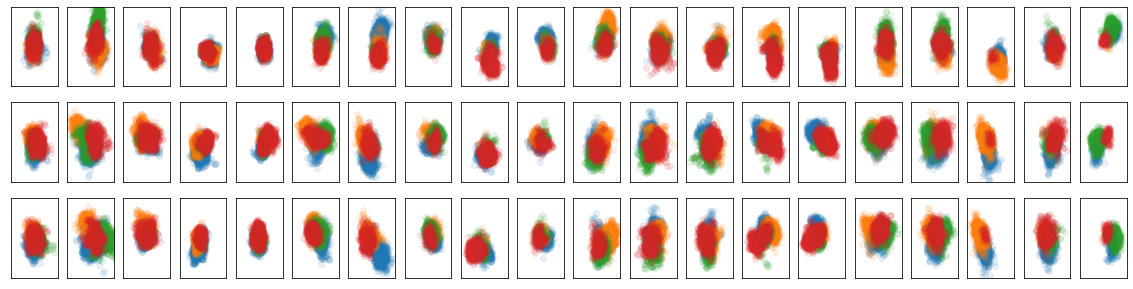

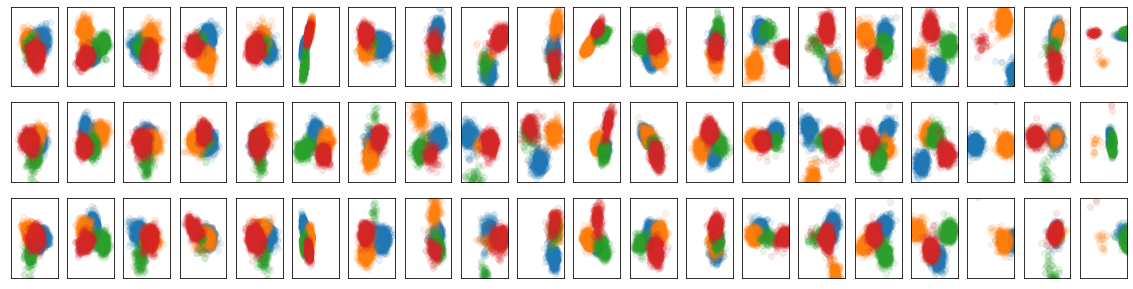

In [74]:
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/mean_representational_distance/lda_4_short/'
N = 20
figure, axes = plt.subplots(3,N)
for i in range(N):
    corners = corners_list_trial[i]
    for j in range(1,5):
        index = np.where(corners == j)[0]
        axes[0,i].scatter(data_transformation_trial_2.lda[i][0,index],data_transformation_trial_2.lda[i][1,index],alpha = 0.1)
        axes[1,i].scatter(data_transformation_trial_2.lda[i][2,index],data_transformation_trial_2.lda[i][3,index],alpha = 0.1)
        axes[2,i].scatter(data_transformation_trial_2.lda[i][1,index],data_transformation_trial_2.lda[i][3,index],alpha = 0.1)

for i in range(N):
    for j in range(3):
        axes[j,i].set_xlim([-6,6])
        axes[j,i].set_ylim([-6,6])
        axes[j,i].set_xticks([])
        axes[j,i].set_yticks([])
        #axes[j,i].set_aspect('equal')
figure.set_size_inches([20,5])
figure.patch.set_facecolor('white')
figure.savefig(figure_path + 'lda_example_overlapping_56165_day.png')

figure, axes = plt.subplots(3,N)
for i in range(N):
    corners = corners_list_trial[i]
    for j in range(1,5):
        index = np.where(corners == j)[0]
        axes[0,i].scatter(data_transformation_trial.lda[i][0,index],data_transformation_trial.lda[i][1,index],alpha = 0.1)
        axes[1,i].scatter(data_transformation_trial.lda[i][1,index],data_transformation_trial.lda[i][2,index],alpha = 0.1)
        axes[2,i].scatter(data_transformation_trial.lda[i][0,index],data_transformation_trial.lda[i][2,index],alpha = 0.1)

for i in range(N):
    for j in range(3):
        axes[j,i].set_xlim([-7,7])
        axes[j,i].set_ylim([-7,7])
        axes[j,i].set_xticks([])
        axes[j,i].set_yticks([])
        #axes[j,i].set_aspect('equal')
figure.set_size_inches([20,5])
figure.patch.set_facecolor('white')
figure.savefig(figure_path + 'lda_example_overlapping_56165.png')

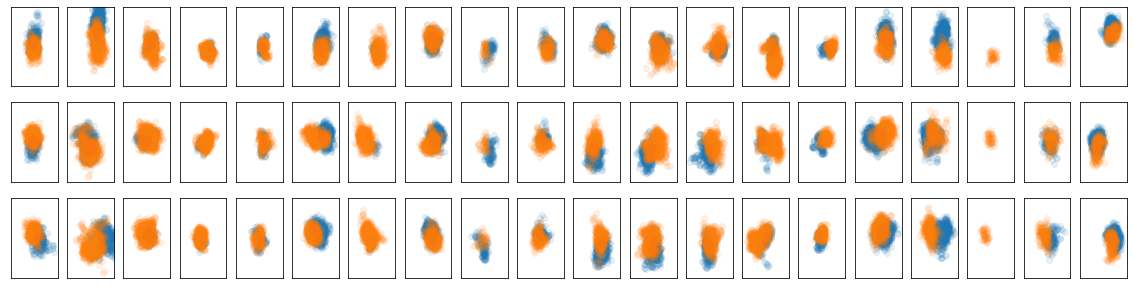

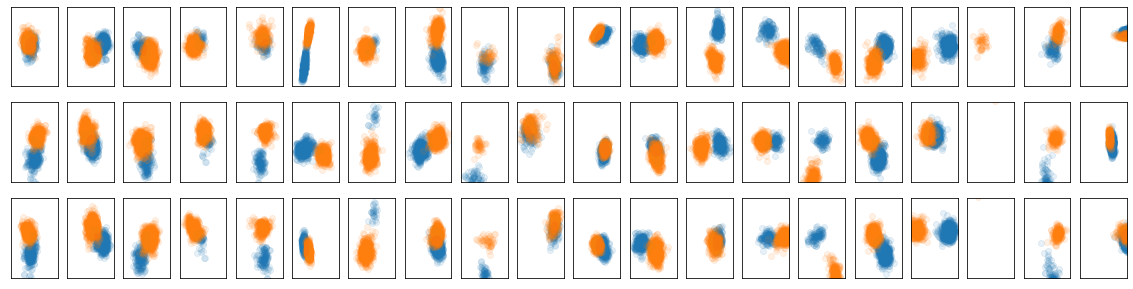

In [73]:
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/mean_representational_distance/lda_4_short/'
N = 20
colors = ['red','blue']
figure, axes = plt.subplots(3,N)
for i in range(N):
    corners = behaviour_list_trial[i]
    for j in range(3,5):
        index = np.where(corners == j)[0]
        axes[0,i].scatter(data_transformation_trial_2.lda[i][0,index],data_transformation_trial_2.lda[i][1,index],alpha = 0.1)
        axes[1,i].scatter(data_transformation_trial_2.lda[i][2,index],data_transformation_trial_2.lda[i][3,index],alpha = 0.1)
        axes[2,i].scatter(data_transformation_trial_2.lda[i][1,index],data_transformation_trial_2.lda[i][3,index],alpha = 0.1)

for i in range(N):
    for j in range(3):
        axes[j,i].set_xlim([-6,6])
        axes[j,i].set_ylim([-6,6])
        axes[j,i].set_xticks([])
        axes[j,i].set_yticks([])
        #axes[j,i].set_aspect('equal')
figure.set_size_inches([20,5])
figure.patch.set_facecolor('white')
figure.savefig(figure_path + 'lda_example_overlapping_56165_beh_day.png')

figure, axes = plt.subplots(3,N)
for i in range(N):
    corners = behaviour_list_trial[i]
    for j in range(3,5):
        index = np.where(corners == j)[0]
        axes[0,i].scatter(data_transformation_trial.lda[i][0,index],data_transformation_trial.lda[i][1,index],alpha = 0.1)
        axes[1,i].scatter(data_transformation_trial.lda[i][1,index],data_transformation_trial.lda[i][2,index],alpha = 0.1)
        axes[2,i].scatter(data_transformation_trial.lda[i][0,index],data_transformation_trial.lda[i][2,index],alpha = 0.1)

for i in range(N):
    for j in range(3):
        axes[j,i].set_xlim([-7,7])
        axes[j,i].set_ylim([-7,7])
        axes[j,i].set_xticks([])
        axes[j,i].set_yticks([])
        #axes[j,i].set_aspect('equal')
figure.set_size_inches([20,5])
figure.patch.set_facecolor('white')
figure.savefig(figure_path + 'lda_example_overlapping_56165_beh.png')

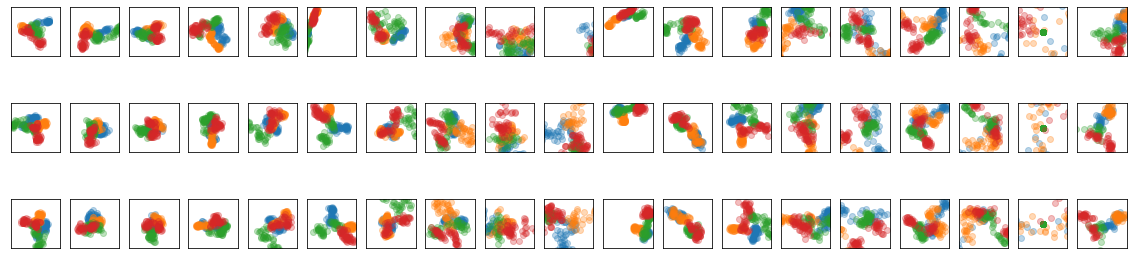

In [72]:
figure = plt.figure()
gs = plt.GridSpec(3, N-1)
#axes = figure.add_subplot(gs[0,0],projection = '3d')

for i in range(N-1):
    axes = figure.add_subplot(gs[0,i])#,projection = '3d')
    axes.scatter(trial_activity.lda[i][0,0,:],trial_activity.lda[i][0,1,:],alpha = 0.3)#,trial_activity.lda[0][0,2,:],alpha = 0.3)
    axes.scatter(trial_activity.lda[i][1,0,:],trial_activity.lda[i][1,1,:],alpha = 0.3)#,trial_activity.lda[0][1,2,:],alpha = 0.3)
    axes.scatter(trial_activity.lda[i][2,0,:],trial_activity.lda[i][2,1,:],alpha = 0.3)#,trial_activity.lda[0][2,2,:],alpha = 0.3)
    axes.scatter(trial_activity.lda[i][3,0,:],trial_activity.lda[i][3,1,:],alpha = 0.3)#,trial_activity.lda[0][3,2,:],alpha = 0.3)
    axes.set_ylim([-3,3])
    axes.set_xlim([-3,3])
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_aspect('equal')
    axes = figure.add_subplot(gs[1,i])#,projection = '3d')
    axes.scatter(trial_activity.lda[i][0,2,:],trial_activity.lda[i][0,1,:],alpha = 0.3)#,trial_activity.lda[0][0,2,:],alpha = 0.3)
    axes.scatter(trial_activity.lda[i][1,2,:],trial_activity.lda[i][1,1,:],alpha = 0.3)#,trial_activity.lda[0][1,2,:],alpha = 0.3)
    axes.scatter(trial_activity.lda[i][2,2,:],trial_activity.lda[i][2,1,:],alpha = 0.3)#,trial_activity.lda[0][2,2,:],alpha = 0.3)
    axes.scatter(trial_activity.lda[i][3,2,:],trial_activity.lda[i][3,1,:],alpha = 0.3)#,trial_activity.lda[0][3,2,:],alpha = 0.3)
    axes.set_ylim([-3,3])
    axes.set_xlim([-3,3])
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_aspect('equal')
    axes = figure.add_subplot(gs[2,i])#,projection = '3d')
    axes.scatter(trial_activity.lda[i][0,1,:],trial_activity.lda[i][0,2,:],alpha = 0.3)#,trial_activity.lda[0][0,2,:],alpha = 0.3)
    axes.scatter(trial_activity.lda[i][1,1,:],trial_activity.lda[i][1,2,:],alpha = 0.3)#,trial_activity.lda[0][1,2,:],alpha = 0.3)
    axes.scatter(trial_activity.lda[i][2,1,:],trial_activity.lda[i][2,2,:],alpha = 0.3)#,trial_activity.lda[0][2,2,:],alpha = 0.3)
    axes.scatter(trial_activity.lda[i][3,1,:],trial_activity.lda[i][3,2,:],alpha = 0.3)#,trial_activity.lda[0][3,2,:],alpha = 0.3)
    axes.set_ylim([-3,3])
    axes.set_xlim([-3,3])
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_aspect('equal')
figure.set_size_inches([25,5])
figure.set_size_inches([20,5])
figure.patch.set_facecolor('white')
figure.savefig(figure_path + 'lda_example_trials_overlapping_56165.png')

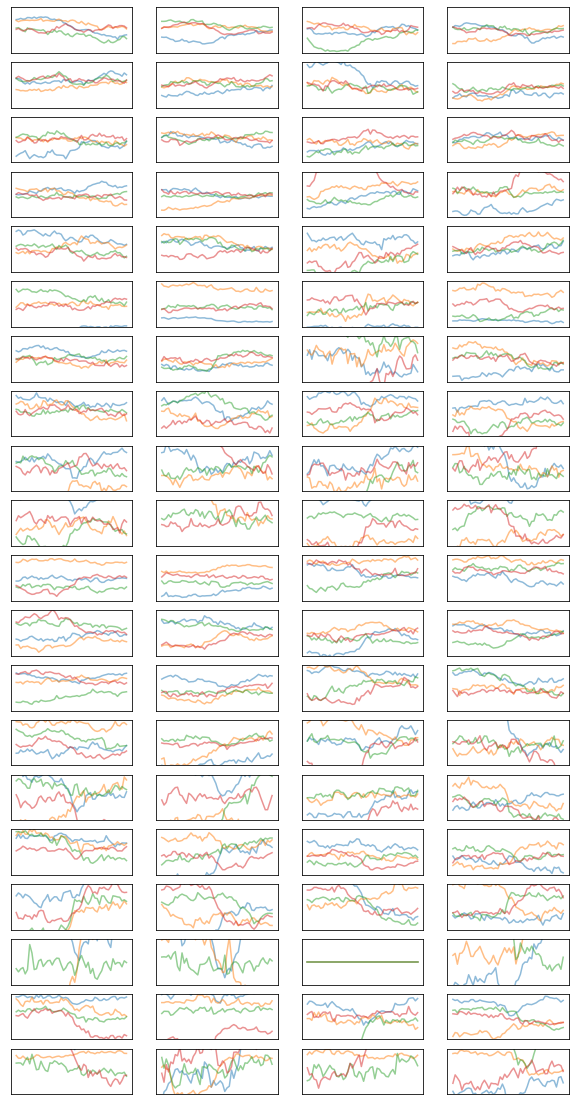

In [11]:
figure = plt.figure()
gs = plt.GridSpec(N, 4)
for i in range(N):
    for j in range(4):
        axes = figure.add_subplot(gs[i,j])#,projection = '3d')
        axes.plot(trial_activity.lda[i][j,:,:].T,alpha = 0.5)#,trial_activity.lda[0][0,2,:],alpha = 0.3)
        axes.set_ylim([-3,3])
        axes.set_xticks([])
        axes.set_yticks([])
        #axes.set_aspect('equal')

figure.set_size_inches([10,20])
figure.patch.set_facecolor('white')
figure.savefig(figure_path + 'lda_example_trials_overlapping_56165_.png')

In [14]:
### example distance
TIME = 50

distance_vector = np.zeros((4,4,N,TIME))
for i in range(N):
    for j in range(TIME):
        for n in range(4):
            for m in range(4):
                x = np.linalg.norm(trial_activity.lda[i][n,:,j] - trial_activity.lda[i][m,:,j])
                distance_vector[n,m,i,j] = x
   

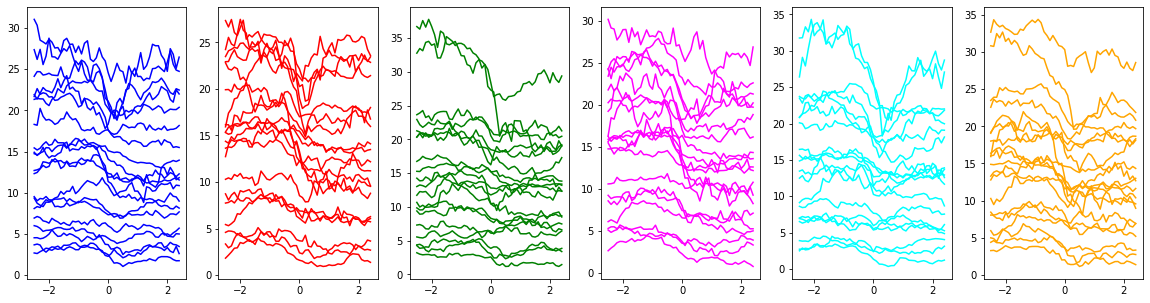

In [16]:
from matplotlib import colors
time = np.arange(0,TIME)/10 - 2.5
color1 = np.linspace(0, 1, TIME)
figure, axes = plt.subplots(1,6)

for i in range(20):
    #plt.scatter(time,distance_vector[1,3,0,:], c = color1 , cmap = 'Blues')
    axes[0].plot(time,distance_vector[0,1,i,:] + i, c = 'b' )#, alpha = 1- i/20)
    axes[1].plot(time,distance_vector[0,2,i,:]+i, c = 'r' )#, alpha = 1-i/20)
    axes[2].plot(time,distance_vector[0,3,i,:]+i, c = 'g')# , alpha = 1-i/20)
    axes[3].plot(time,distance_vector[1,2,i,:]+i, c = 'magenta')# , alpha = 1- i/20)
    axes[4].plot(time,distance_vector[1,3,i,:]+i, c = 'cyan')# , alpha = 1- i/20)
    axes[5].plot(time,distance_vector[2,3,i,:]+i, c = 'orange')# , alpha = 1- i/20)
    
figure.set_size_inches([20,5])


In [246]:
trial_activity, trial_activity_shuffle, events_id, distance = compute_distance(activity_list_trial,data_transformation_trial,period,combination_corners_trial,id_target_combination,N_SHUFFLINGS,data_transformation_trial.trials,metric = metric_use,trial_flag = True)

figure = plt.figure()
gs = plt.GridSpec(3, 10) 
#axes = figure.add_subplot(gs[0,0],projection = '3d')

for i in range(10):
    axes = figure.add_subplot(gs[0,i])#,projection = '3d')
    axes.scatter(trial_activity.lda[i][0,0,:],trial_activity.lda[i][0,1,:],alpha = 0.3)#,trial_activity.lda[0][0,2,:],alpha = 0.3)
    axes.scatter(trial_activity.lda[i][1,0,:],trial_activity.lda[i][1,1,:],alpha = 0.3)#,trial_activity.lda[0][1,2,:],alpha = 0.3)
    axes.scatter(trial_activity.lda[i][2,0,:],trial_activity.lda[i][2,1,:],alpha = 0.3)#,trial_activity.lda[0][2,2,:],alpha = 0.3)
    axes.scatter(trial_activity.lda[i][3,0,:],trial_activity.lda[i][3,1,:],alpha = 0.3)#,trial_activity.lda[0][3,2,:],alpha = 0.3)
    axes.set_ylim([-3,3])
    axes.set_xlim([-3,3])
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_aspect('equal')
    axes = figure.add_subplot(gs[1,i])#,projection = '3d')
    axes.scatter(trial_activity.lda[i][0,3,:],trial_activity.lda[i][0,1,:],alpha = 0.3)#,trial_activity.lda[0][0,2,:],alpha = 0.3)
    axes.scatter(trial_activity.lda[i][1,3,:],trial_activity.lda[i][1,1,:],alpha = 0.3)#,trial_activity.lda[0][1,2,:],alpha = 0.3)
    axes.scatter(trial_activity.lda[i][2,3,:],trial_activity.lda[i][2,1,:],alpha = 0.3)#,trial_activity.lda[0][2,2,:],alpha = 0.3)
    axes.scatter(trial_activity.lda[i][3,3,:],trial_activity.lda[i][3,1,:],alpha = 0.3)#,trial_activity.lda[0][3,2,:],alpha = 0.3)
    axes.set_ylim([-3,3])
    axes.set_xlim([-3,3])
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_aspect('equal')
    axes = figure.add_subplot(gs[2,i])#,projection = '3d')
    axes.scatter(trial_activity.lda[i][0,3,:],trial_activity.lda[i][0,2,:],alpha = 0.3)#,trial_activity.lda[0][0,2,:],alpha = 0.3)
    axes.scatter(trial_activity.lda[i][1,3,:],trial_activity.lda[i][1,2,:],alpha = 0.3)#,trial_activity.lda[0][1,2,:],alpha = 0.3)
    axes.scatter(trial_activity.lda[i][2,3,:],trial_activity.lda[i][2,2,:],alpha = 0.3)#,trial_activity.lda[0][2,2,:],alpha = 0.3)
    axes.scatter(trial_activity.lda[i][3,3,:],trial_activity.lda[i][3,2,:],alpha = 0.3)#,trial_activity.lda[0][3,2,:],alpha = 0.3)
    axes.set_ylim([-3,3])
    axes.set_xlim([-3,3])
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_aspect('equal')
figure.set_size_inches([25,5])
figure.set_size_inches([20,5])
figure.patch.set_facecolor('white')
figure.savefig(figure_path + 'lda_example_trials_overlapping1_56165.png')

SyntaxError: invalid non-printable character U+00A0 (3871171519.py, line 4)

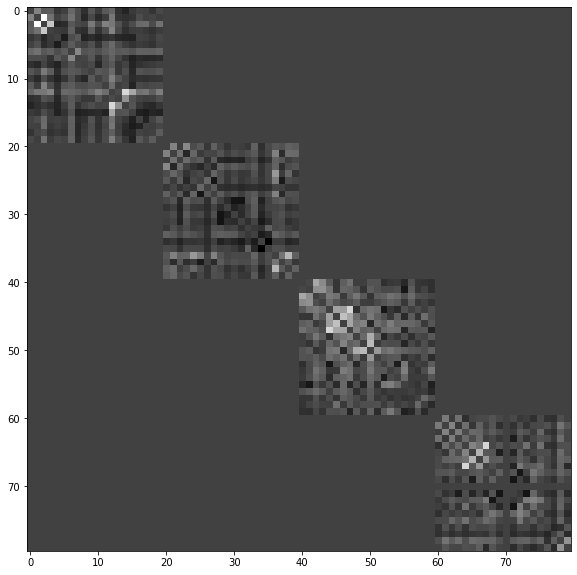

In [143]:
figure, axes = plt.subplots()
axes.imshow((distance.lda - np.mean(distance.lda))/np.std(distance.lda), cmap = 'gray')
figure.set_size_inches([10,10])

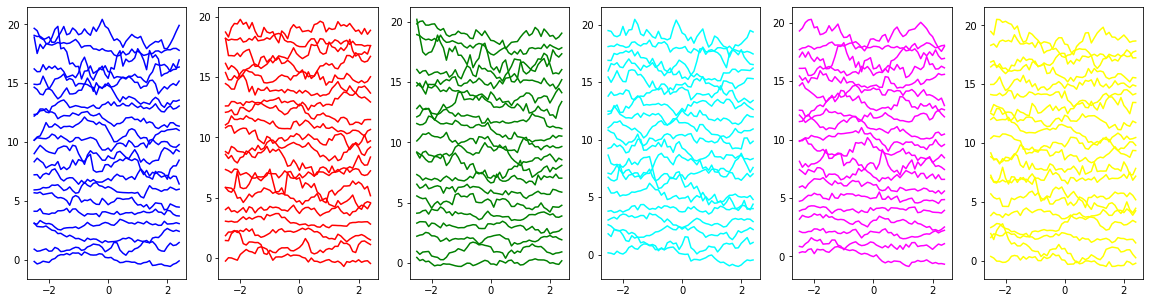

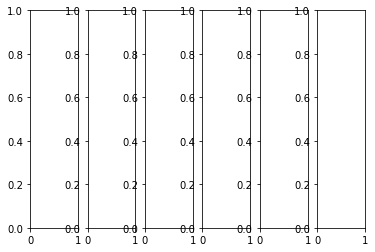

In [32]:
### example distance

distance_vector = np.zeros((4,4,N,TIME))
for i in range(N):
    for j in range(TIME):
        for n in range(4):
            for m in range(4):
                x = np.linalg.norm(trial_activity2.lda[i][n,:,j] - trial_activity2.lda[i][m,:,j])
                distance_vector[n,m,i,j] = x
                
time = np.arange(0,TIME)/10 - 2.5
pairs = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]
colors = ['blue','red','green','cyan','magenta','yellow']

figure, axes = plt.subplots(1,6)

for i in range(N):
    #plt.scatter(time,distance_vector[1,3,0,:], c = color1 , cmap = 'Blues')
    for n in range(6):
        axes[n].plot(time,distance_vector[pairs[n][0],pairs[n][1],i,:]-np.mean(distance_vector[pairs[n][0],pairs[n][1],i,:]) + i, c = colors[n]  )#, alpha = 1- i/20)

figure.set_size_inches([20,5]) 
figure.patch.set_facecolor('white')
figure.savefig(figure_path + 'lda_example_trials_distance_dayly.png')

figure, axes = plt.subplots(1,6)


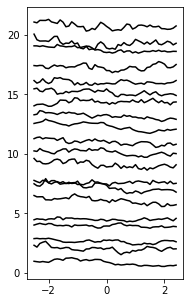

In [33]:

figure, axes = plt.subplots()

for i in range(20):
    #plt.scatter(time,distance_vector[1,3,0,:], c = color1 , cmap = 'Blues')
    axes.plot(time,np.mean(np.mean(distance_vector[:,:,i,:],axis=0),axis=0) + i, c = 'k' )#, alpha = 1- i/20)

figure.set_size_inches([2.8,5]) 
figure.patch.set_facecolor('white')
figure.savefig(figure_path + 'lda_example_trials_overlapping_56165_mean_distance_dayly.png')

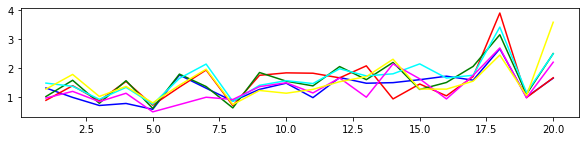

In [34]:
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/mean_representational_distance/lda_4/'

trial = np.arange(1,21)
color1 = np.linspace(0, 1, 100)
figure, axes = plt.subplots()

    #plt.scatter(time,distance_vector[1,3,0,:], c = color1 , cmap = 'Blues')
for n in range(6):
    axes.plot(trial,np.mean(distance_vector[pairs[n][0],pairs[n][1],:,:],axis=1), c = colors[n] )

figure.set_size_inches([10,2]) 
figure.patch.set_facecolor('white')
figure.savefig(figure_path + 'lda_example_trials_overlapping_56165_mean_distance2.png')

In [24]:
np.mean(np.mean(np.mean(distance_vector,axis=3),axis=0),axis=0).shape

(20,)

In [25]:
np.mean(distance_vector[pairs[n][0],pairs[n][1],:,:],axis=1).shape

(20,)

In [37]:

distance_vector_s = np.zeros((trial_activity_shuffle.lda[0].shape[0],4,4,N,TIME))
for i in range(N):
    for j in range(TIME):
        for n in range(4):
            for m in range(4):
                for s in range(trial_activity_shuffle.lda[i].shape[0]):
                    x = np.linalg.norm(trial_activity_shuffle2.lda[i][s,n,:,j] - trial_activity_shuffle2.lda[i][s,m,:,j])
                    distance_vector_s[s,n,m,i,j] = x
                


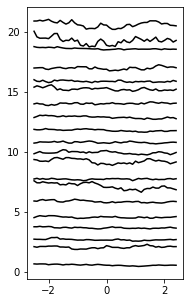

In [38]:
figure, axes = plt.subplots()

for i in range(N):
    #plt.scatter(time,distance_vector[1,3,0,:], c = color1 , cmap = 'Blues')
    axes.plot(time,np.mean(np.mean(np.mean(distance_vector_s[:,:,:,i,:],axis=0),axis=0),axis=0) + i, c = 'k' )#, alpha = 1- i/20)

figure.set_size_inches([2.8,5]) 
figure.patch.set_facecolor('white')
#figure.savefig(figure_path + 'lda_example_trials_overlapping_56165_mean_distance_shuffle.png')

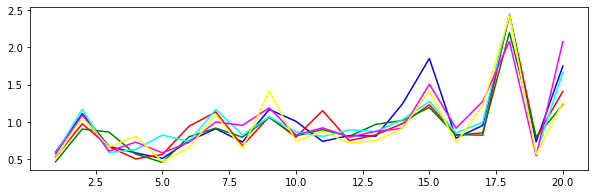

In [39]:
trial = np.arange(1,21)
color1 = np.linspace(0, 1, 100)
figure, axes = plt.subplots()

    #plt.scatter(time,distance_vector[1,3,0,:], c = color1 , cmap = 'Blues')
for n in range(6):
    axes.plot(trial,np.mean(np.mean(distance_vector_s[pairs[n][0],pairs[n][1],:,:],axis=0),axis=1), c = colors[n] )

figure.set_size_inches([10,3]) 
figure.patch.set_facecolor('white')
figure.savefig(figure_path + 'lda_example_trials_overlapping_56165_mean_distance2_shuffle.png')

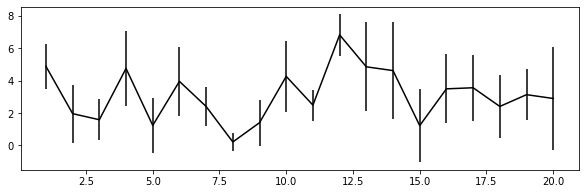

In [40]:
trial = np.arange(1,21)
color1 = np.linspace(0, 1, 100)
figure, axes = plt.subplots()

    #plt.scatter(time,distance_vector[1,3,0,:], c = color1 , cmap = 'Blues')
vector = np.zeros((6,20))
for n in range(6):
    x = np.mean(np.mean(distance_vector_s[pairs[n][0],pairs[n][1],:,:],axis=0),axis=1)
    z = np.std(np.mean(distance_vector_s[pairs[n][0],pairs[n][1],:,:],axis=0),axis=1)
    
    y = np.mean(distance_vector[pairs[n][0],pairs[n][1],:,:],axis=1)
    vector[n,:] = (y-x)/z
    
axes.errorbar(trial,np.mean(vector,axis=0),np.std(vector,axis=0), c = 'k' )

figure.set_size_inches([10,3]) 
figure.patch.set_facecolor('white')
#figure.savefig(figure_path + 'lda_example_trials_overlapping_56165_mean_distance2_shuffle2.png')